In [16]:
import jax
jax.config.update('jax_default_device',jax.devices()[1])
jax.config.update('jax_enable_x64',True)
import equinox as eqx
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from jax import grad, vmap
import optax
from diffrax import (
    diffeqsolve, ODETerm, Dopri5, ControlTerm, 
    Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree, Heun,
    WeaklyDiagonalControlTerm,PIDController
)
from tqdm.auto import tqdm

from stochastic_interpolant.kernel_transport.rpc import lazy_pivoted_partial_cholesky
from stochastic_interpolant.kernel_transport.KernelTools import (
    get_gaussianRBF,vectorize_kfunc,
    get_sum_of_kernels,get_poly_kernel
)

from stochastic_interpolant.dataloaders import DatasetSampler, GaussianReferenceSampler, IndependenceCouplingSampler, build_trainloader, testloader_factory
from stochastic_interpolant.loss_functions import get_linear_interpolants, get_loss_functions, root_prod_gamma

from functools import partial
plt.style.use('ggplot')

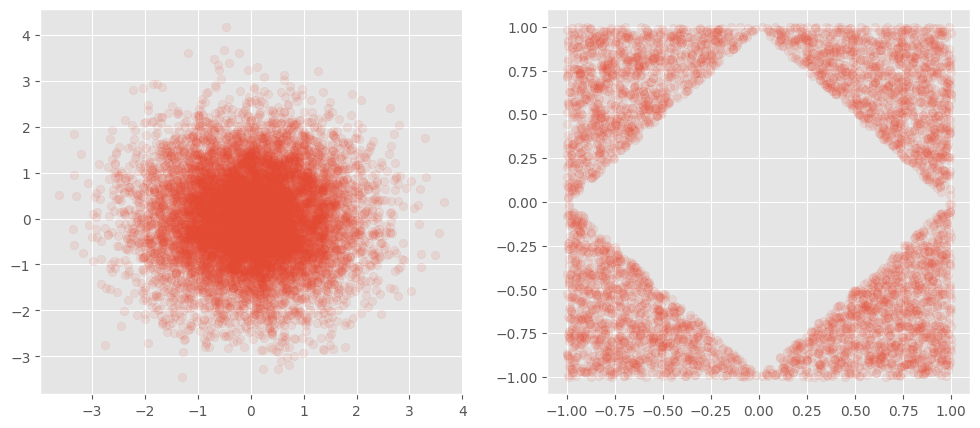

In [17]:
num_target = 5000
key = jax.random.PRNGKey(10)
target_samples = jax.random.uniform(key,shape = (10*num_target,2),minval=-1,maxval=1)
target_samples = 1 * target_samples[jnp.sum(jnp.abs(target_samples),1)>1.][:num_target]

num_reference = 10000
key = jax.random.PRNGKey(15)
reference_samples = jax.random.normal(key=key,shape=(num_reference,2))
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(reference_samples[:,0],reference_samples[:,1],alpha = 0.1)
plt.subplot(1,2,2)
plt.scatter(target_samples[:,0],target_samples[:,1],alpha = 0.1)
plt.show()

In [173]:
I,It = get_linear_interpolants()

gamma = root_prod_gamma
gammadot = vmap(vmap(grad(gamma)))

def gamma(t):
    return t*(1-t)#jnp.sqrt(2*t*(1-t)+1e-8)

gammadot = vmap(vmap(grad(gamma)))


loss_b,loss_eta = get_loss_functions(I,It,gamma,gammadot)

data_coupling_sampler = IndependenceCouplingSampler(
    GaussianReferenceSampler((2,)),
    DatasetSampler(target_samples)
    )

In [174]:
from stochastic_interpolant.kernel_transport.ksi import KernelModel
from stochastic_interpolant.kernel_transport.KernelTools import get_matern_five_half

#k = get_sum_of_kernels([get_gaussianRBF(0.25),get_poly_kernel(deg = 4,c = 1)],[1,1])
k = get_sum_of_kernels([get_matern_five_half(0.2),get_matern_five_half(0.12)],[1,1])
k = get_sum_of_kernels([get_matern_five_half(0.4),get_matern_five_half(0.15)],[1,1])#get_matern_five_half(0.2)
b_model = KernelModel(3,2,k,num_anchors = 2500)
num_select_center = 50000
t,x,y,z = next(build_trainloader(num_select_center,jax.random.PRNGKey(124),data_coupling_sampler))
rpc_results = b_model.get_set_rpc_anchors(jnp.hstack([t,I(t,x,y)]),129)

  0%|          | 0/2500 [00:00<?, ?it/s]

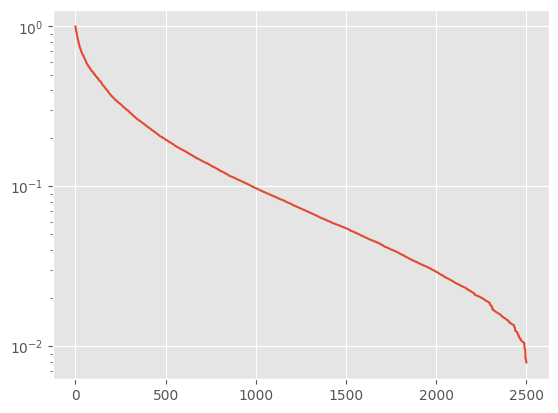

In [175]:
plt.plot(rpc_results[2]/rpc_results[2][0])
plt.yscale('log')

In [176]:
from stochastic_interpolant.loss_functions import loss_pieces
from stochastic_interpolant.kernel_transport.ksi import kernel_transport_loader
batch_size = 10000
num_batches = 400
train_loader = build_trainloader(batch_size,jax.random.PRNGKey(124),data_coupling_sampler)
test_factory = testloader_factory(batch_size,jax.random.PRNGKey(32498130),data_coupling_sampler)

XyLoader = kernel_transport_loader(train_loader,I,It,gamma,gammadot)
AtA,Atb = b_model.accumulate_system(XyLoader,num_batches)

  0%|          | 0/400 [00:00<?, ?it/s]

In [177]:
from kernel_code.KernelTools import diagpart
from stochastic_interpolant.model_training import evaluate_test_loss
from scipy.optimize import minimize_scalar

def reg_loss(alpha):
    coeffs = jnp.linalg.solve(AtA + 10**(alpha) * b_model.kmat,Atb)
    b_model.weights = coeffs
    return evaluate_test_loss(b_model,test_factory(),loss_b,20)

result = minimize_scalar(reg_loss,(-10,0.),bounds = (-10,0),method = 'bounded',options = {'maxiter':15})
coeffs = jnp.linalg.solve(AtA + 10**(result.x) * b_model.kmat,Atb)
b_model.weights = coeffs

In [178]:
result

 message: Maximum number of function calls reached.
 success: False
  status: 1
     fun: -0.8892427069623551
       x: -1.6126682976971796
     nit: 15
    nfev: 15

In [20]:
result

 message: Maximum number of function calls reached.
 success: False
  status: 1
     fun: -1.0269365
       x: -2.2801452
     nit: 15
    nfev: 15

(-4.0, 4.0)

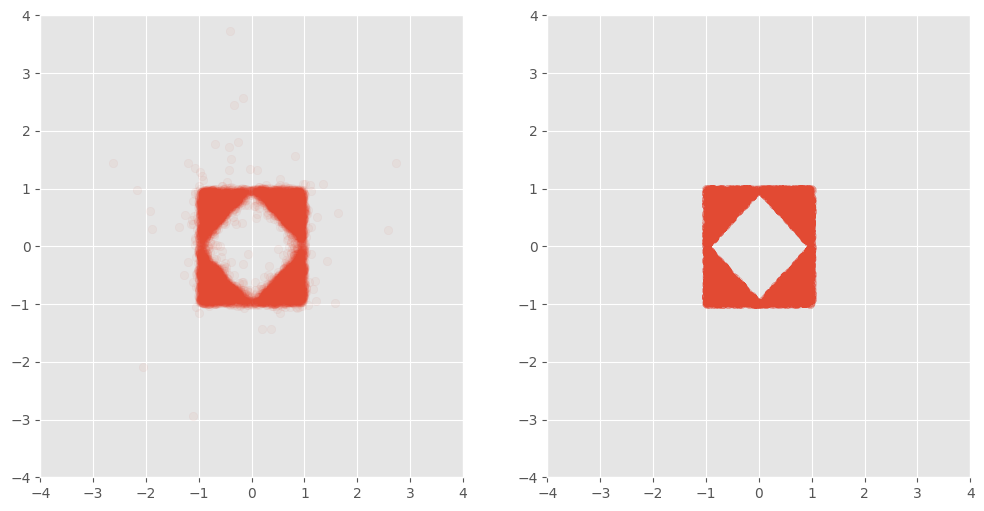

In [179]:
vmapped_b_model = vmap(b_model)
@eqx.filter_jit
def dX_t(t,x,args):
    t_vec = jnp.ones((len(x),1))*t
    return vmapped_b_model(jnp.hstack([t_vec,x]))

X0 = reference_samples.copy()
t0, t1 = 0.0,1.

solver = Dopri5()
stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)
#saveat = SaveAt(dense=True)

sol = diffeqsolve(ODETerm(dX_t), solver, t0, t1,dt0 = 0.001,  y0=X0)#,stepsize_controller = stepsize_controller)
#X = sol.evaluate(1.0)
#print(X)  

X = sol.ys[0]
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(X[:,0],X[:,1],alpha = 0.05)

lim = 4
plt.xlim(-lim,lim)
plt.ylim(-lim,lim)
plt.subplot(1,2,2)
#plt.scatter(target_samples[:,0],target_samples[:,1],alpha = 0.1)
interp_dist = I(t1,x,y) + gamma(t1)*z
plt.scatter(interp_dist[:,0],interp_dist[:,1],alpha = 0.02)
plt.xlim(-lim,lim)
plt.ylim(-lim,lim)

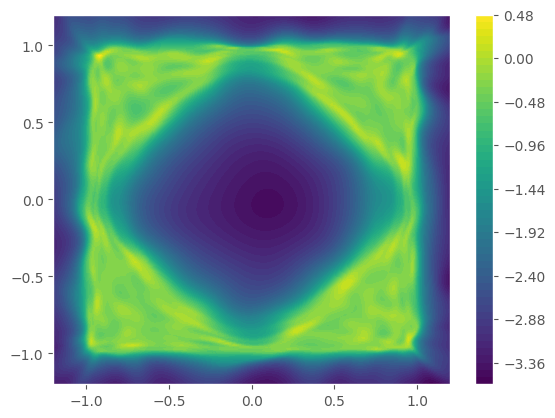

In [193]:
def dxt_single(t,x,args):
    tx = jnp.hstack([1-t,x])
    return -1 * b_model(tx)

def backward_ode(x1):
    return diffeqsolve(ODETerm(dxt_single), solver, 0., 1. ,dt0 = 0.005,  y0=x1).ys[0]

ode_jac = jax.jacrev(backward_ode)

from jax.scipy.stats import multivariate_normal
zero_point = jnp.array([0.,0])

@jax.jit
def density_est(x):
    return multivariate_normal.pdf(backward_ode(x),jnp.zeros(2),jnp.eye(2))*jnp.linalg.det(ode_jac(x))

vec_density_est = jax.vmap(density_est)

x_grid = jnp.linspace(-1.2,1.2,200)
y_grid = jnp.linspace(-1.2,1.2,200)

XX,YY = jnp.meshgrid(x_grid,y_grid)
density_points = jnp.vstack([XX.flatten(),YY.flatten()]).T
density_vals = vec_density_est(density_points)
plt.tricontourf(density_points[:,0],density_points[:,1],jnp.log10(density_vals),50)#,levels = jnp.linspace(0,3))
plt.colorbar()

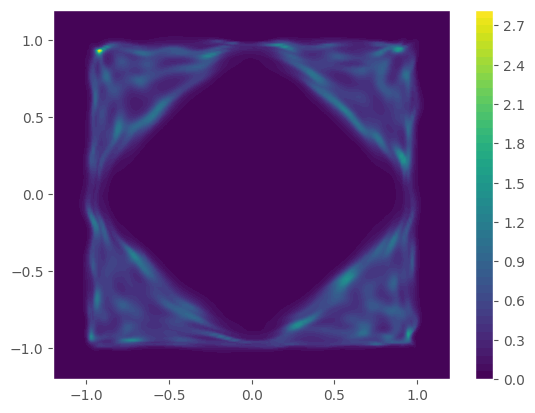

In [195]:
plt.tricontourf(density_points[:,0],density_points[:,1],density_vals,50)#,levels = jnp.linspace(0,3))
plt.colorbar()

In [194]:
jnp.sum(density_vals)*jnp.diff(x_grid)[0]**2

Array(0.99585619, dtype=float64)

In [52]:
jnp.array([0,0.])

Array([0., 0.], dtype=float64)

In [55]:
result = backward_ode(jnp.array([0,0.])).ys[0]

Array([-0.02844864, -0.01437466], dtype=float64)

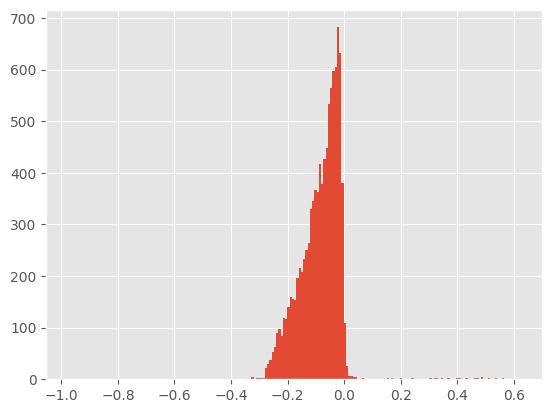

In [28]:
plt.hist(np.array(jnp.log10(jnp.max(jnp.abs(X),axis=1))),200)
plt.show()